# Interpretacja modeli – analiza SHAP

Celem tego etapu projektu jest interpretacja predykcji najlepszych modeli klasyfikacyjnych
przy użyciu metody **SHAP (SHapley Additive exPlanations)**.

Analiza SHAP pozwala zrozumieć:
- które cechy mają największy wpływ na decyzje modeli,
- w jakim kierunku (pozytywnym lub negatywnym) dana cecha wpływa na predykcję,
- czy zachowanie modeli jest spójne z intuicją domenową.

W ramach tego etapu interpretowane są **dwa najlepsze modele** wybrane we wcześniejszych częściach projektu:
- najlepszy model klasyczny (**Random Forest**),
- najlepszy model Deep Learning (**MLP**).

Dla zachowania pełnej spójności, do interpretacji wykorzystywane są te same dane,
ten sam podział trening / walidacja oraz te same transformacje cech,
które były używane podczas trenowania modeli.

## Analiza SHAP – model Random Forest

W pierwszej kolejności przeprowadzono analizę SHAP dla najlepszego modelu klasycznego –
**Random Forest**, wybranego na podstawie strojenia hiperparametrów (GridSearchCV)
oraz najwyższej wartości macro F1-score na zbiorze walidacyjnym.

Model ten został zapisany jako kompletny pipeline, obejmujący:
- preprocessing danych (standaryzacja cech numerycznych oraz kodowanie One-Hot cech kategorycznych),
- wytrenowany klasyfikator Random Forest.

Takie podejście gwarantuje, że interpretacja SHAP dotyczy dokładnie tych samych
transformacji cech, które były używane podczas uczenia modelu.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shap
import joblib

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings

In [12]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [13]:
train_df = pd.read_csv("../data/processed/train_clean.csv")

X = train_df.drop(columns="Credit_Score")
y = train_df["Credit_Score"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train.shape, X_val.shape

((80000, 23), (20000, 23))

W tej sekcji ponownie wczytano oczyszczony zbiór danych
oraz wykonano podział na zbiór treningowy i walidacyjny
z zachowaniem proporcji klas (*stratified split*).

Celem jest zachowanie spójności z wcześniejszym etapem trenowania modeli,
tak aby interpretacja SHAP dotyczyła dokładnie tego samego rozkładu danych.

In [14]:
rf_pipe = joblib.load("../models/best_rf_pipeline.joblib")

rf_pipe

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains s

Do analizy SHAP wykorzystano najlepszy model Random Forest
wybrany na podstawie strojenia hiperparametrów (GridSearchCV).

Model jest wczytywany jako pełny pipeline,
zawierający zarówno preprocessing, jak i wytrenowany klasyfikator,
co gwarantuje spójność transformacji cech.

Pipeline został rozdzielony na:
- część preprocessingową (skalowanie + kodowanie kategorii),
- właściwy model Random Forest.

Jest to wymagane, ponieważ SHAP operuje na danych
po transformacjach wejściowych, a nie na surowych cechach.

In [15]:
rf_preprocess = rf_pipe.named_steps["prep"]
rf_model = rf_pipe.named_steps["model"]

In [16]:
X_train_proc = rf_preprocess.transform(X_train)
feature_names = rf_preprocess.get_feature_names_out()

np.random.seed(42)
idx = np.random.choice(X_train_proc.shape[0], size=min(500, X_train_proc.shape[0]), replace=False)
X_shap = X_train_proc[idx]

if hasattr(X_shap, "toarray"):
    X_shap = X_shap.toarray()

len(feature_names), X_train_proc.shape, X_shap.shape

(6315, (80000, 6315), (500, 6315))

Na potrzeby analizy SHAP dane treningowe zostały przekształcone
za pomocą preprocessingu wchodzącego w skład pipeline'u Random Forest.

Dzięki temu SHAP analizuje dokładnie te same cechy,
na których operuje model (po skalowaniu i One-Hot Encoding).

In [17]:
print("X_shap type:", type(X_shap))
print("X_shap shape:", getattr(X_shap, "shape", None))
print("X_shap dtype:", getattr(X_shap, "dtype", None))

X_shap type: <class 'numpy.ndarray'>
X_shap shape: (500, 6315)
X_shap dtype: float64


Ze względu na dużą liczbę obserwacji oraz bardzo wysoką liczbę cech
(po kodowaniu zmiennych kategorycznych),
do analizy SHAP wykorzystano losową próbkę 500 obserwacji
ze zbioru treningowego.

Pozwala to znacząco ograniczyć czas obliczeń
przy zachowaniu reprezentatywności wyników.

W przypadku gdy dane po preprocessingu mają postać macierzy rzadkiej,
zostały one przekonwertowane do tablicy NumPy.

Jest to wymagane, ponieważ SHAP oczekuje danych
w postaci gęstej macierzy numerycznej.

Sprawdzono typ danych, kształt macierzy oraz typ numeryczny
wejścia przekazywanego do SHAP,
aby upewnić się, że dane są poprawnie przygotowane
i nie zawierają błędów strukturalnych.

In [7]:
explainer_rf = shap.Explainer(rf_model, X_shap, feature_names=feature_names)
sv_rf = explainer_rf(X_shap)

class_idx = list(rf_model.classes_).index("Good")
print("Classes:", rf_model.classes_, "| class_idx for Good:", class_idx)

vals = sv_rf.values
if vals.ndim == 3:
    shap_values_good = vals[:, :, class_idx]
else:
    shap_values_good = vals

100%|===================| 1496/1500 [05:46<00:00]        

Classes: ['Good' 'Poor' 'Standard'] | class_idx for Good: 0


## Obliczenie wartości SHAP dla klasy „Good”

Problem klasyfikacji ma charakter wieloklasowy, dlatego wartości SHAP
są obliczane osobno dla każdej klasy decyzyjnej.

W tej części skupiono się na analizie klasy **Good**,
która odpowiada klientom o najlepszej jakości kredytowej.

Wartości SHAP dla tej klasy zostały wyodrębnione na podstawie indeksu klasy
w wyjściu modelu Random Forest, co umożliwia analizę wpływu poszczególnych cech
na prawdopodobieństwo przypisania obserwacji do klasy *Good*.

C:\Users\mikol\AppData\Local\Temp\ipykernel_2984\2293683974.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


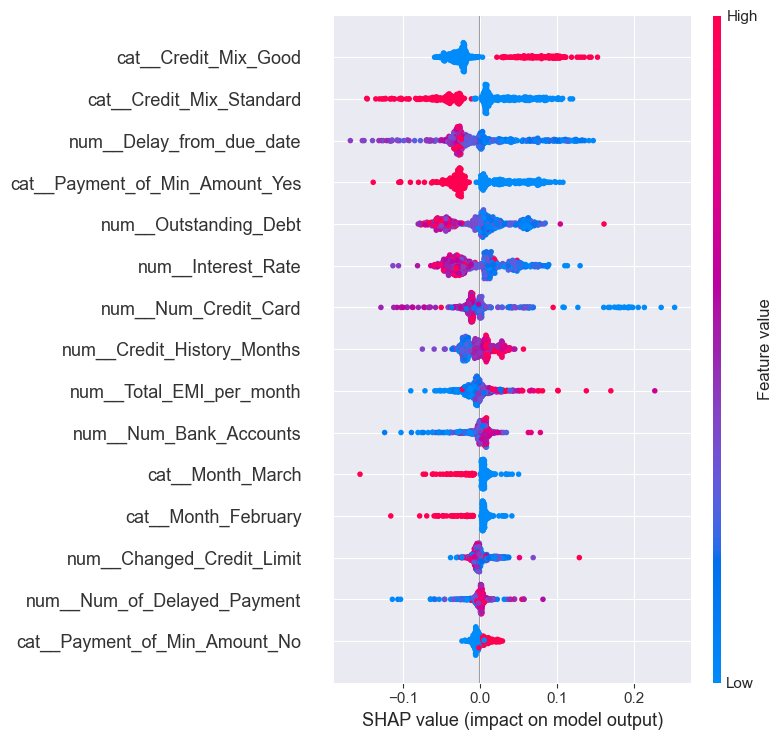

In [8]:
shap.summary_plot(
    shap_values_good,
    X_shap,
    feature_names=feature_names,
    max_display=15
)

Wykres SHAP przedstawia cechy o największym **globalnym wpływie**
na predykcję klasy *Good* w modelu Random Forest.

Pozycja cech na osi Y odzwierciedla ich istotność globalną,
natomiast znak oraz wartość SHAP na osi X pokazują kierunek
i siłę wpływu danej cechy na decyzję modelu.

Największy wpływ na klasyfikację jako *Good* mają:
- **Credit_Mix** – szczególnie obecność kategorii *Good* zwiększa prawdopodobieństwo tej klasy,
- **Delay_from_due_date** – mniejsze opóźnienia sprzyjają klasyfikacji *Good*,
- **Payment_of_Min_Amount** – regularne spłaty minimalnej kwoty wpływają pozytywnie,
- **Outstanding_Debt** oraz **Interest_Rate** – niższe wartości są powiązane z lepszą oceną kredytową.

Wyniki są spójne z intuicją domenową i wskazują,
że model poprawnie identyfikuje kluczowe czynniki ryzyka kredytowego.

C:\Users\mikol\AppData\Local\Temp\ipykernel_2984\1160712514.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


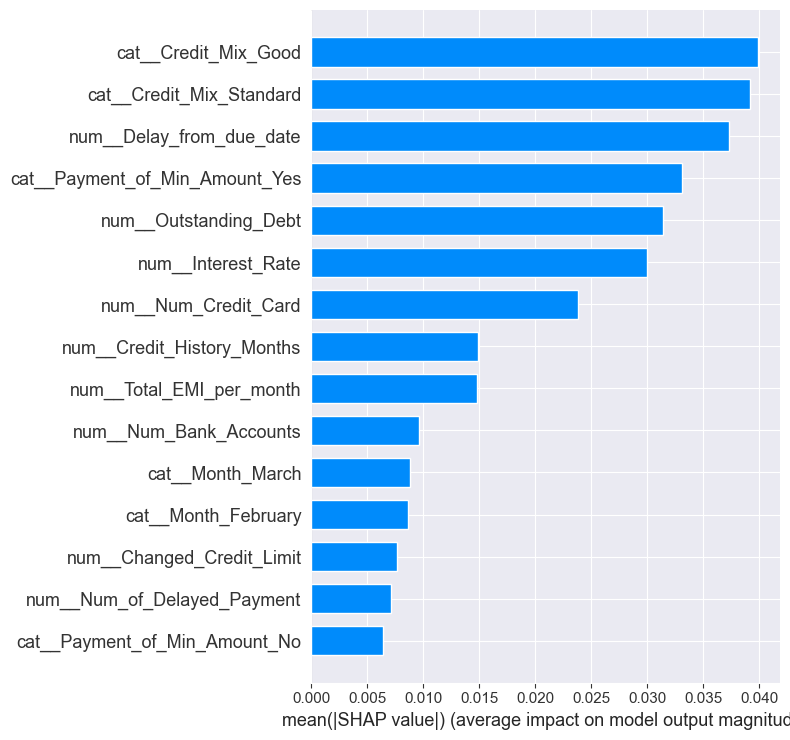

In [9]:
shap.summary_plot(
    shap_values_good,
    X_shap,
    feature_names=feature_names,
    plot_type="bar",
    max_display=15
)

Dla lepszej czytelności i porównania znaczenia cech
przedstawiono również wykres słupkowy SHAP,
który pokazuje średnią bezwzględną wartość SHAP
jako miarę globalnej istotności cech.

Największy globalny wpływ na predykcję klasy *Good*
mają cechy związane z historią kredytową,
terminowością spłat oraz poziomem zadłużenia.

### Podsumowanie analizy SHAP – Random Forest

Analiza SHAP dla modelu Random Forest pokazuje, że decyzje modelu są w dużej mierze
determinowane przez cechy związane z:
- historią kredytową klienta,
- terminowością spłat,
- poziomem zadłużenia.

Wpływ najważniejszych cech jest spójny z intuicją domenową,
co potwierdza, że model uczy się sensownych i interpretowalnych zależności.

W kolejnej części przeprowadzona zostanie analogiczna analiza SHAP
dla najlepszego modelu Deep Learning (MLP),
co umożliwi bezpośrednie porównanie interpretowalności obu podejść.

======================================================================================================================

## SHAP – Deep Learning (MLP)

W kolejnym kroku przeprowadzono analizę SHAP dla najlepszego modelu Deep Learning – **MLP (Multilayer Perceptron)**, wybranego na podstawie najwyższej wartości macro F1-score spośród testowanych architektur sieci neuronowych.

Model został wczytany jako kompletny pipeline obejmujący:
- preprocessing danych (skalowanie cech numerycznych oraz kodowanie One-Hot cech kategorycznych),
- wytrenowany klasyfikator MLP.

Ze względu na brak struktury drzewiastej w modelu MLP, do analizy wykorzystano metodę **Kernel SHAP**, która umożliwia aproksymację wpływu cech na predykcję modelu.

Wczytuję zapisany pipeline dla najlepszego modelu MLP.
Pipeline zawiera:
- preprocessing (skalowanie cech numerycznych + One-Hot Encoding cech kategorycznych),
- model klasyfikacyjny **MLPClassifier**.

In [18]:
dl_pipe = joblib.load("../models/best_dl_pipeline.joblib")

dl_pipe

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains s

In [19]:
dl_preprocess = dl_pipe.named_steps["prep"]
dl_model = dl_pipe.named_steps["model"]

In [20]:
# preprocess
X_train_proc_dl = dl_preprocess.transform(X_train)

np.random.seed(42)
idx_bg = np.random.choice(X_train_proc_dl.shape[0], size=100, replace=False)
idx_explain = np.random.choice(X_train_proc_dl.shape[0], size=50, replace=False)

X_bg = X_train_proc_dl[idx_bg]
X_explain = X_train_proc_dl[idx_explain]

if hasattr(X_bg, "toarray"):
    X_bg = X_bg.toarray()
    X_explain = X_explain.toarray()

X_bg.shape, X_explain.shape

((100, 6315), (50, 6315))

Ze względu na wysoki koszt obliczeniowy metody Kernel SHAP:
- jako zbiór tła (background) wykorzystano losową próbkę 100 obserwacji,
- do wyjaśnienia wybrano 50 losowych obserwacji ze zbioru treningowego.

Takie podejście pozwala znacząco ograniczyć czas obliczeń przy zachowaniu interpretowalności wyników.

In [21]:
def predict_proba_dl(X):
    return dl_model.predict_proba(X)

In [22]:
explainer_dl = shap.KernelExplainer(
    predict_proba_dl,
    X_bg
)

Definiuję funkcję zwracającą prawdopodobieństwa klas, aby Kernel SHAP mógł analizować wpływ cech na predykcje modelu MLP.
Na tej podstawie obliczane są wartości SHAP, które pokazują znaczenie poszczególnych cech dla decyzji modelu.
Ze względu na złożoność obliczeń analiza wykonywana jest na losowej próbce danych.

In [23]:
shap_values_dl = explainer_dl.shap_values(X_explain)

100%|██████████| 50/50 [03:22<00:00,  4.05s/it]


In [24]:
print(dl_model.classes_)
class_idx_dl = 0

[0 1 2]


### Obliczenie wartości SHAP dla klasy „Good” (MLP)

Podobnie jak w przypadku Random Forest, analiza SHAP została przeprowadzona dla klasy **Good**, aby zbadać, które cechy zwiększają lub zmniejszają prawdopodobieństwo przypisania klienta do tej klasy w modelu MLP.

C:\Users\mikol\IdeaProjects\CreditScore_AI\.venv\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


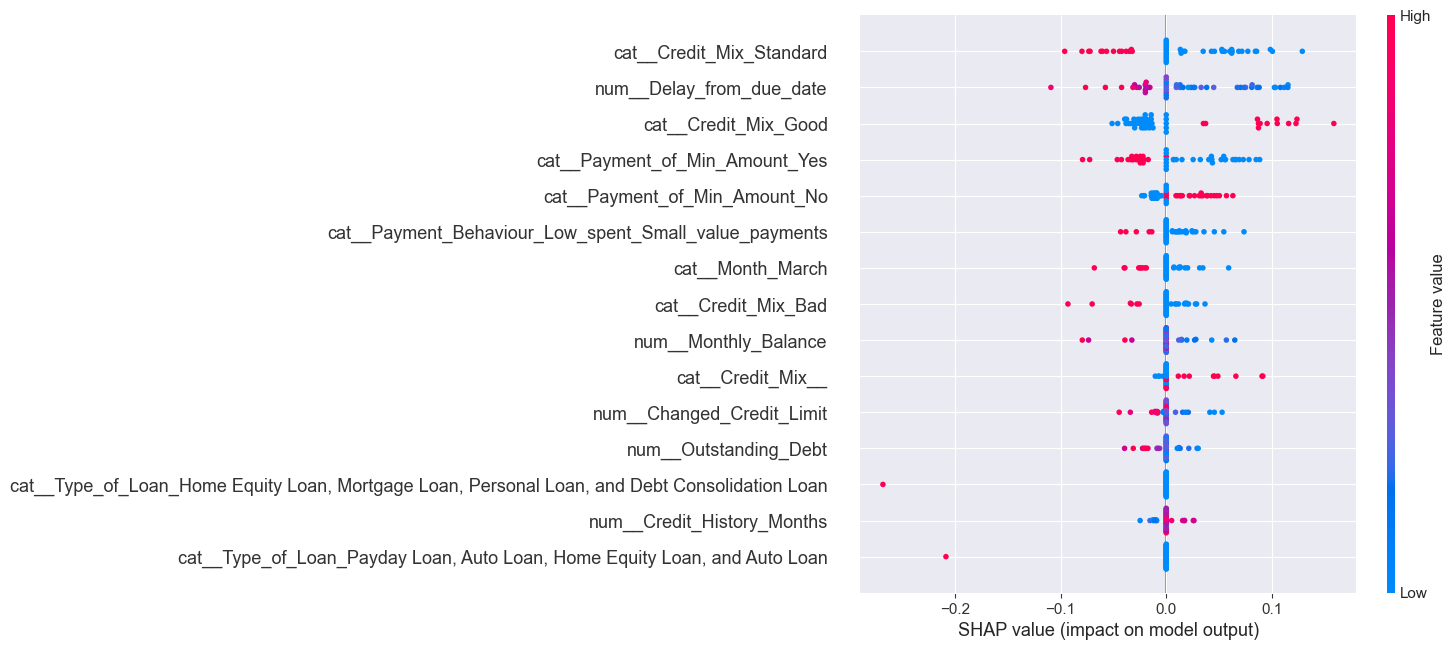

In [26]:
feature_names_dl = dl_preprocess.get_feature_names_out()
class_idx_dl = 0  # Good

sv_good = shap_values_dl[:, :, class_idx_dl]  # (50, 6315)
plt.figure(figsize=(12, 7))
shap.summary_plot(
    sv_good,
    X_explain,
    feature_names=feature_names_dl,
    max_display=15
)
plt.show()

Wykres SHAP przedstawia cechy, które miały największy wpływ na przypisanie klientów
do klasy **Good** w modelu MLP.

Najważniejsze obserwacje:
- największy wpływ mają cechy związane ze strukturą kredytu (*Credit Mix*),
opóźnieniami w spłatach oraz zachowaniem płatniczym,
- wysokie wartości opóźnień oraz niekorzystny credit mix obniżają
prawdopodobieństwo klasy *Good*,
- stabilna historia kredytowa i terminowe regulowanie zobowiązań
zwiększają szanse na pozywną klasyfikację.

Analiza SHAP potwierdza, że model DL podejmuje decyzje w oparciu o logiczne
i zgodne z intuicją zależności.

C:\Users\mikol\IdeaProjects\CreditScore_AI\.venv\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


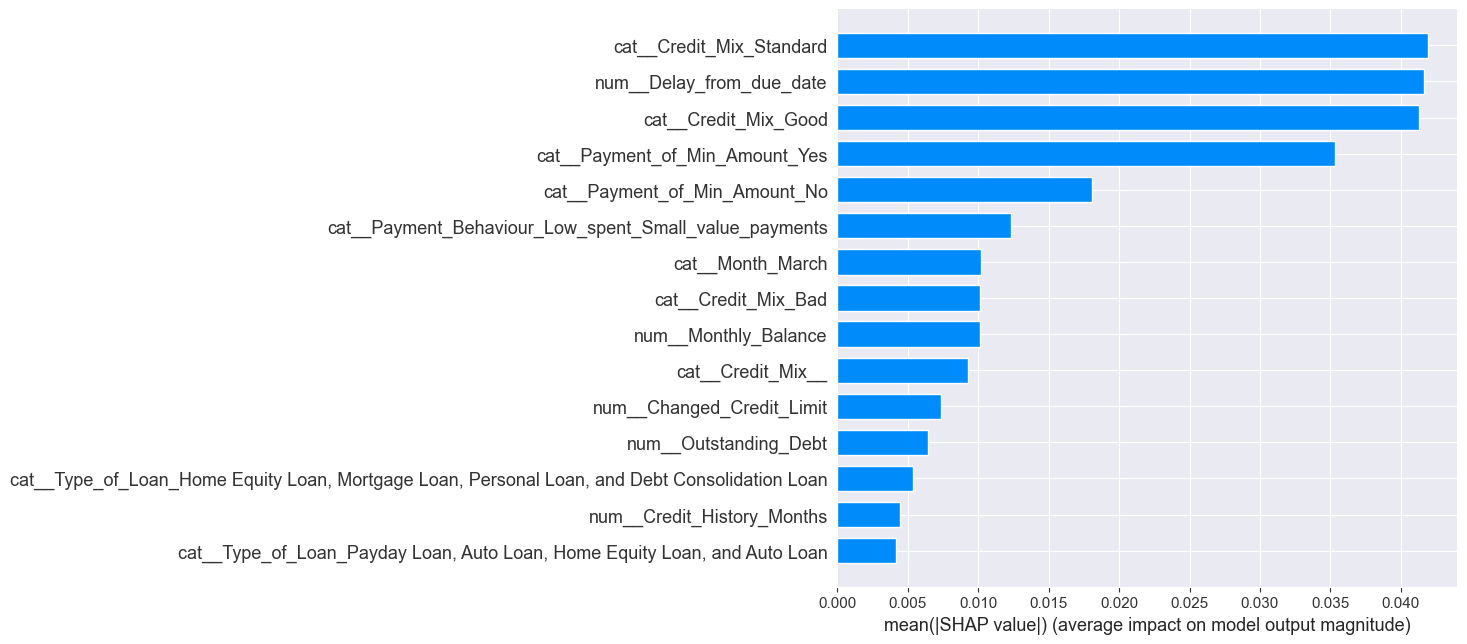

In [27]:
plt.figure(figsize=(12, 7))
shap.summary_plot(
    sv_good,
    X_explain,
    feature_names=feature_names_dl,
    plot_type="bar",
    max_display=15
)
plt.show()

Wykres słupkowy SHAP przedstawia średni bezwzględny wpływ cech na predykcję klasy **Good**.
Największe znaczenie mają cechy związane z **miksami kredytowymi (Credit_Mix)** oraz **opóźnieniami w spłacie (Delay_from_due_date)**, co wskazuje, że struktura zobowiązań i terminowość płatności są kluczowe dla pozytywnej oceny kredytowej.
Pozostałe cechy, takie jak saldo miesięczne czy liczba kont bankowych, mają mniejszy, lecz nadal zauważalny wpływ na decyzję modelu.

### Podsumowanie analizy SHAP – MLP

Analiza SHAP dla modelu MLP pokazuje, że sieć neuronowa opiera swoje decyzje na podobnych grupach cech jak model Random Forest, w szczególności:
- cechach związanych z **Credit Mix**,
- opóźnieniach w spłatach,
- zachowaniach płatniczych,
- stabilności historii kredytowej.

Pomimo bardziej złożonej architektury, model MLP uczy się zależności zgodnych z intuicją domenową, co potwierdza poprawność procesu trenowania oraz preprocessing danych.

================================================================================================================================================================

## Podsumowanie porównawcze analizy SHAP (Random Forest vs MLP)

W ramach analizy interpretowalności porównano wartości SHAP dla dwóch najlepszych modeli:
- klasycznego modelu **Random Forest**,
- modelu **Deep Learning – MLP**.

Celem porównania było sprawdzenie, czy oba modele opierają swoje decyzje na podobnych cechach oraz czy identyfikowane zależności są spójne z intuicją domenową.

### Wspólne obserwacje

Analiza SHAP pokazuje, że oba modele:
- wskazują **zbliżone grupy cech jako najistotniejsze** dla predykcji klasy *Good*,
- przypisują wysoką wagę cechom związanym z:
- **strukturą kredytu (Credit Mix)**,
- **terminowością spłat (Delay from due date)**,
- **zachowaniami płatniczymi (Payment Behaviour, Payment of Min Amount)**,
- **poziomem zadłużenia oraz historią kredytową**.

W obu przypadkach wyższa stabilność finansowa oraz regularność spłat zwiększają prawdopodobieństwo pozytywnej klasyfikacji, natomiast opóźnienia i niekorzystna struktura kredytu obniżają ocenę kredytową.

### Różnice pomiędzy modelami

- **Random Forest** wykazuje bardziej „punktową” interpretowalność – wpływ poszczególnych cech jest wyraźniej skoncentrowany, co jest charakterystyczne dla modeli drzewiastych.
- **MLP** rozkłada wpływ cech w sposób bardziej rozproszony, co wynika z nieliniowej natury sieci neuronowych oraz wysokiej wymiarowości danych po kodowaniu One-Hot.

Pomimo tych różnic, kierunek wpływu kluczowych cech pozostaje spójny pomiędzy modelami.

### Wnioski

Analiza SHAP potwierdza, że:
- oba modele uczą się **sensownych i logicznych zależności**,
- decyzje predykcyjne są zgodne z wiedzą domenową dotyczącą ryzyka kredytowego,
- brak przewagi jakościowej MLP nad Random Forest nie wynika z błędów uczenia, lecz z charakteru danych tablicowych o bardzo wysokiej wymiarowości po kodowaniu.

Wyniki te uzasadniają wybór **Random Forest jako modelu głównego** do dalszej analizy interpretowalnej, przy jednoczesnym potwierdzeniu poprawności działania modelu Deep Learning.